In [1]:
# 

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device and domain
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epsilon = 1.0
pi = np.pi
tmin, tmax = 0.0, 1.0
xmin, xmax = -pi, pi
lb = torch.tensor([tmin, xmin], dtype=torch.float32, device=device)
ub = torch.tensor([tmax, xmax], dtype=torch.float32, device=device)

def scale_input(x):
    return 2.0 * (x - lb) / (ub - lb) - 1.0

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.linear = nn.Linear(width, width)
        self.activation = Swish()

    def forward(self, x):
        return x + self.activation(self.linear(x))

class NetU(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 50)
        self.blocks = nn.Sequential(*[ResidualBlock(50) for _ in range(6)])
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = self.input(x)
        x = self.blocks(x)
        return self.output(x)

class NetV(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 30)
        self.blocks = nn.Sequential(*[ResidualBlock(30) for _ in range(4)])
        self.output = nn.Linear(30, 1)

    def forward(self, x):
        x = self.input(x)
        x = self.blocks(x)
        return self.output(x)



In [3]:

class CoupledPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_u = NetU()
        self.net_v = NetV()

    def forward(self, x):
        x_scaled = scale_input(x)
        return self.net_u(x_scaled), self.net_v(x_scaled)

def residuals(model, X_r):
    X_r.requires_grad_(True)
    t, x = X_r[:, 0:1], X_r[:, 1:2]
    u, v = model(X_r)

    grads_u = torch.autograd.grad(u, X_r, torch.ones_like(u), create_graph=True)[0]
    grads_v = torch.autograd.grad(v, X_r, torch.ones_like(v), create_graph=True)[0]

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]

    u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    v_xx = torch.autograd.grad(v_x, X_r, torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

    uv = u * v
    uv_x = torch.autograd.grad(uv, X_r, torch.ones_like(uv), create_graph=True)[0][:, 1:2]

    r1 = u_t - u_xx - 2 * u * u_x + uv_x
    r2 = v_t - v_xx - 2 * v * v_x + uv_x
    return r1, r2

def u_exact(x, t):
    return torch.exp(-t) * torch.sin(x)

def v_exact(x, t):
    return torch.exp(-t) * torch.sin(x)

def generate_data(N_0=100, N_b=100, N_r=5000):
    x_0 = (xmax - xmin) * torch.rand((N_0, 1), device=device) + xmin
    t_0 = torch.full_like(x_0, tmin)
    X_0 = torch.cat([t_0, x_0], dim=1)
    u_0 = u_exact(x_0, t_0)
    v_0 = v_exact(x_0, t_0)

    t_b = (tmax - tmin) * torch.rand((N_b, 1), device=device) + tmin
    x_b0 = torch.full_like(t_b, xmin)
    x_b1 = torch.full_like(t_b, xmax)
    X_b = torch.cat([torch.cat([t_b, x_b0], dim=1), torch.cat([t_b, x_b1], dim=1)], dim=0)
    u_b = u_exact(X_b[:, 1:2], X_b[:, 0:1])
    v_b = v_exact(X_b[:, 1:2], X_b[:, 0:1])

    t_r = (tmax - tmin) * torch.rand((N_r, 1), device=device) + tmin
    x_r = (xmax - xmin) * torch.rand((N_r, 1), device=device) + xmin
    X_r = torch.cat([t_r, x_r], dim=1)

    return X_0, u_0, v_0, X_b, u_b, v_b, X_r

def loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b,
            weight_pde=1.0, weight_ic=10.0, weight_bc=10.0):
    
    r1, r2 = residuals(model, X_r)
    loss_pde = torch.mean(r1**2) + torch.mean(r2**2)

    u_pred_0, v_pred_0 = model(X_0)
    loss_ic = torch.mean((u_pred_0 - u_0) ** 2) + torch.mean((v_pred_0 - v_0) ** 2)

    u_pred_b, v_pred_b = model(X_b)
    loss_bc = torch.mean((u_pred_b - u_b) ** 2) + torch.mean((v_pred_b - v_b) ** 2)

    total_loss = weight_pde * loss_pde + weight_ic * loss_ic + weight_bc * loss_bc
    return total_loss

def train_model(model, X_0, u_0, v_0, X_b, u_b, v_b, X_r,
                epochs=20000, patience=100, lr=1e-3):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch:04d} | Loss = {loss.item():.4e} | LR = {scheduler.get_last_lr()[0]:.2e}")

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if best_state:
        model.load_state_dict(best_state)

    print("Switching to LBFGS optimizer for fine-tuning...")
    optimizer_lbfgs = optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-8)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b)
        loss.backward()
        return loss

    optimizer_lbfgs.step(closure)
    return model

def predict(model, N_plot=200):
    x_plot = torch.linspace(xmin, xmax, N_plot, device=device)
    t_plot = torch.full_like(x_plot, tmax)
    X_plot = torch.stack([t_plot, x_plot], dim=1)
    with torch.no_grad():
        u_pred, v_pred = model(X_plot)
    u_exact_vals = u_exact(x_plot, t_plot)
    v_exact_vals = v_exact(x_plot, t_plot)
    return x_plot.cpu().numpy(), u_pred.cpu().numpy(), v_pred.cpu().numpy(), u_exact_vals.cpu().numpy(), v_exact_vals.cpu().numpy()



In [4]:

# Run
model = CoupledPINN().to(device)
X_0, u_0, v_0, X_b, u_b, v_b, X_r = generate_data()
model = train_model(model, X_0, u_0, v_0, X_b, u_b, v_b, X_r)


Epoch 0000 | Loss = 1.1287e+01 | LR = 1.00e-03
Epoch 0100 | Loss = 2.7210e+00 | LR = 1.00e-03
Epoch 0200 | Loss = 4.2824e-02 | LR = 1.00e-03
Epoch 0300 | Loss = 1.4900e-02 | LR = 1.00e-03
Epoch 0400 | Loss = 9.5784e-03 | LR = 1.00e-03
Epoch 0500 | Loss = 6.3147e-03 | LR = 5.00e-04
Epoch 0600 | Loss = 5.3625e-03 | LR = 5.00e-04
Epoch 0700 | Loss = 4.5543e-03 | LR = 5.00e-04
Epoch 0800 | Loss = 3.8763e-03 | LR = 5.00e-04
Epoch 0900 | Loss = 3.3143e-03 | LR = 5.00e-04
Epoch 1000 | Loss = 2.8513e-03 | LR = 2.50e-04
Epoch 1100 | Loss = 2.6486e-03 | LR = 2.50e-04
Epoch 1200 | Loss = 2.4579e-03 | LR = 2.50e-04
Epoch 1300 | Loss = 2.2789e-03 | LR = 2.50e-04
Epoch 1400 | Loss = 2.1114e-03 | LR = 2.50e-04
Epoch 1500 | Loss = 1.9546e-03 | LR = 1.25e-04
Epoch 1600 | Loss = 1.8791e-03 | LR = 1.25e-04
Epoch 1700 | Loss = 1.8039e-03 | LR = 1.25e-04
Epoch 1800 | Loss = 1.7292e-03 | LR = 1.25e-04
Epoch 1900 | Loss = 1.6552e-03 | LR = 1.25e-04
Epoch 2000 | Loss = 1.5822e-03 | LR = 6.25e-05
Epoch 2100 | 

In [5]:

def plot_results(x, u_pred, v_pred, u_exact, v_exact):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, u_exact, 'r', label='u_exact')
    plt.plot(x, u_pred, 'k--', label='u_pred')
    plt.title('u(x, t=1)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, v_exact, 'b', label='v_exact')
    plt.plot(x, v_pred, 'k--', label='v_pred')
    plt.title('v(x, t=1)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def compute_error_metrics(model, t_eval=1.0, N_points=500):
    x = torch.linspace(xmin, xmax, N_points, device=device)
    t = torch.full_like(x, t_eval)
    X = torch.stack([t, x], dim=1)
    with torch.no_grad():
        u_pred, v_pred = model(X)
    u_true = u_exact(x, t)
    v_true = v_exact(x, t)

    u_err = torch.abs(u_pred.squeeze() - u_true)
    v_err = torch.abs(v_pred.squeeze() - v_true)

    u_Linf = u_err.max().item()
    u_L2 = torch.sqrt(torch.mean(u_err ** 2)).item()
    v_Linf = v_err.max().item()
    v_L2 = torch.sqrt(torch.mean(v_err ** 2)).item()

    print(f"\nError Metrics at t = {t_eval}")
    print(f"{'Metric':<12} {'u(x,t)':<12} {'v(x,t)':<12}")
    print(f"{'L_inf':<12} {u_Linf:<12.4e} {v_Linf:<12.4e}")
    print(f"{'L_2':<12} {u_L2:<12.4e} {v_L2:<12.4e}")

def save_plot(x, u_pred, v_pred, u_exact, v_exact, filename='pinn_plot_1.png'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, u_exact, 'r', label='u_exact')
    plt.plot(x, u_pred, 'k--', label='u_pred')
    plt.title('u(x, t=1)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, v_exact, 'b', label='v_exact')
    plt.plot(x, v_pred, 'k--', label='v_pred')
    plt.title('v(x, t=1)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"Plot saved as {filename}")

In [6]:
x, u_pred, v_pred, u_ex, v_ex = predict(model)


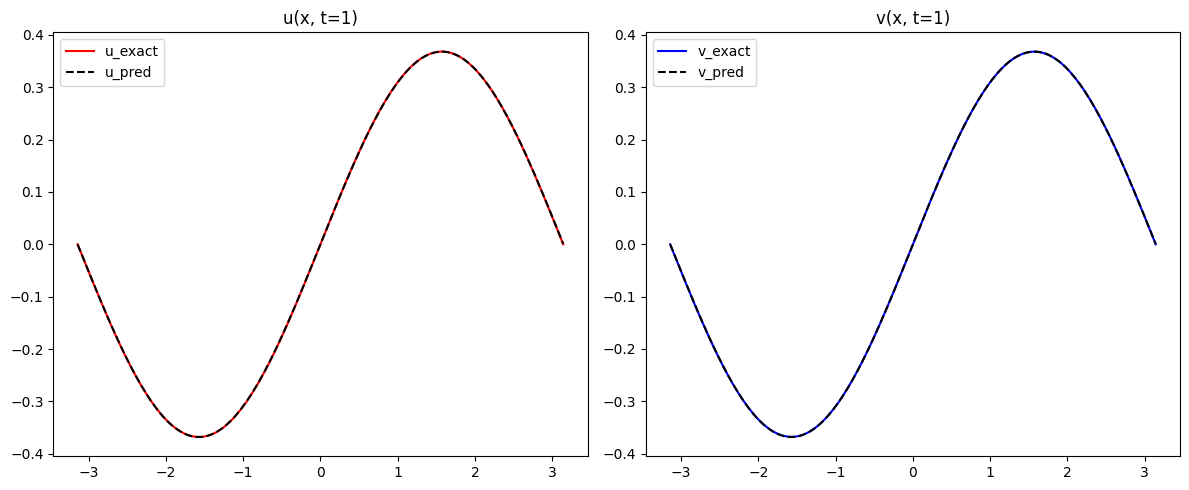

In [7]:
plot_results(x, u_pred, v_pred, u_ex, v_ex)


In [8]:
compute_error_metrics(model)



Error Metrics at t = 1.0
Metric       u(x,t)       v(x,t)      
L_inf        8.6048e-04   5.4707e-04  
L_2          3.1967e-04   2.1470e-04  


Plot saved as pinn_plot_1.png


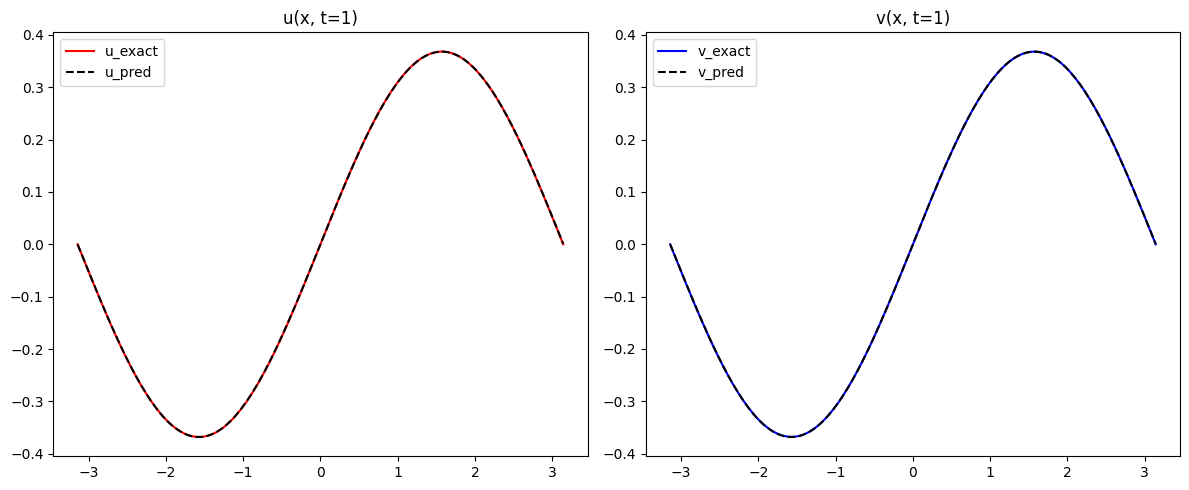

In [9]:
save_plot(x, u_pred, v_pred, u_ex, v_ex)

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_surface_like_image(X, T, Z, label='v(x,t)', cmap='spring', filename='surface_plot.png'):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Note: Transpose T and X to swap axes for matching your image orientation
    surf = ax.plot_surface(X, T, Z, cmap=cmap, edgecolor='k', linewidth=0.3, antialiased=True)

    # Axes labels to match your image
    ax.set_xlabel("x", labelpad=10)
    ax.set_ylabel("t", labelpad=10)
    ax.set_zlabel(label, labelpad=10)

    # Adjust viewing angle to match your reference image
    ax.view_init(elev=20, azim=-120)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


In [11]:
plot_surface_like_image(X_np, T_np, v_pred_grid, label='v(x,t)', cmap='spring', filename='v_surface_plot.png')


NameError: name 'X_np' is not defined

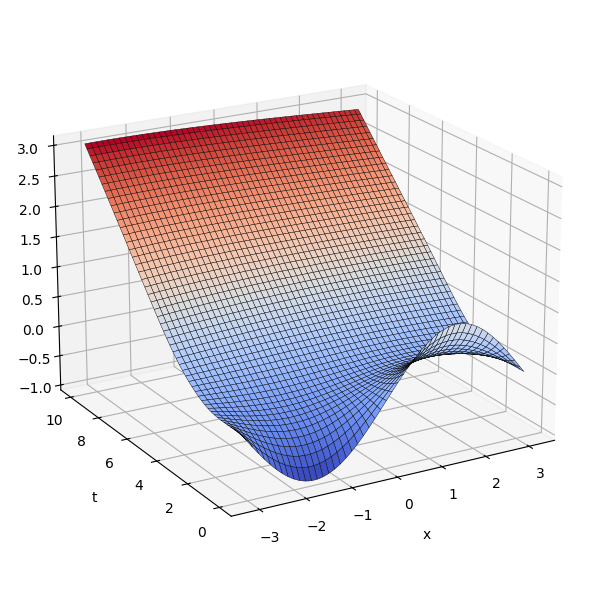

In [ ]:
plot_surface_like_image(X_np, T_np, u_pred_grid, label='u(x,t)', cmap='coolwarm', filename='u_surface_plot.png')


In [12]:
def compare_pinn_vs_exact(model, t_values=[1, 2, 3, 4, 5], N_x=200):
    import matplotlib.pyplot as plt

    x = torch.linspace(xmin, xmax, N_x, device=device)
    
    fig_u, axes_u = plt.subplots(1, len(t_values), figsize=(20, 4))
    fig_v, axes_v = plt.subplots(1, len(t_values), figsize=(20, 4))

    for i, t_val in enumerate(t_values):
        t = torch.full_like(x, float(t_val))
        X = torch.stack([t, x], dim=1)

        with torch.no_grad():
            u_pred, v_pred = model(X)
        u_true = u_exact(x, t)
        v_true = v_exact(x, t)

        # Plot for u(x,t)
        axes_u[i].plot(x.cpu(), u_true.cpu(), 'k-', label='Exact u', linewidth=2)
        axes_u[i].plot(x.cpu(), u_pred.cpu(), 'r--', label='Predicted u', linewidth=1.5)
        axes_u[i].set_title(f"u(x, t={t_val})")
        axes_u[i].legend()
        axes_u[i].grid(True)

        # Plot for v(x,t)
        axes_v[i].plot(x.cpu(), v_true.cpu(), 'k-', label='Exact v', linewidth=2)
        axes_v[i].plot(x.cpu(), v_pred.cpu(), 'b--', label='Predicted v', linewidth=1.5)
        axes_v[i].set_title(f"v(x, t={t_val})")
        axes_v[i].legend()
        axes_v[i].grid(True)

    fig_u.suptitle("Comparison of u(x,t): Exact vs. PINN", fontsize=16)
    fig_v.suptitle("Comparison of v(x,t): Exact vs. PINN", fontsize=16)

    fig_u.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_v.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


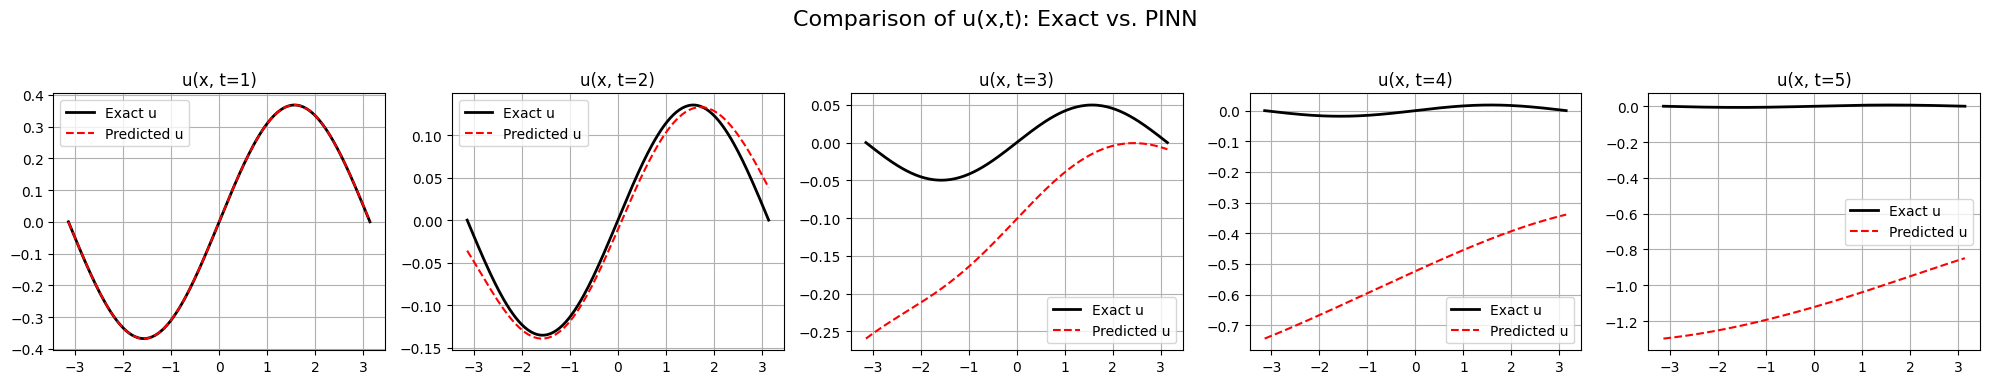

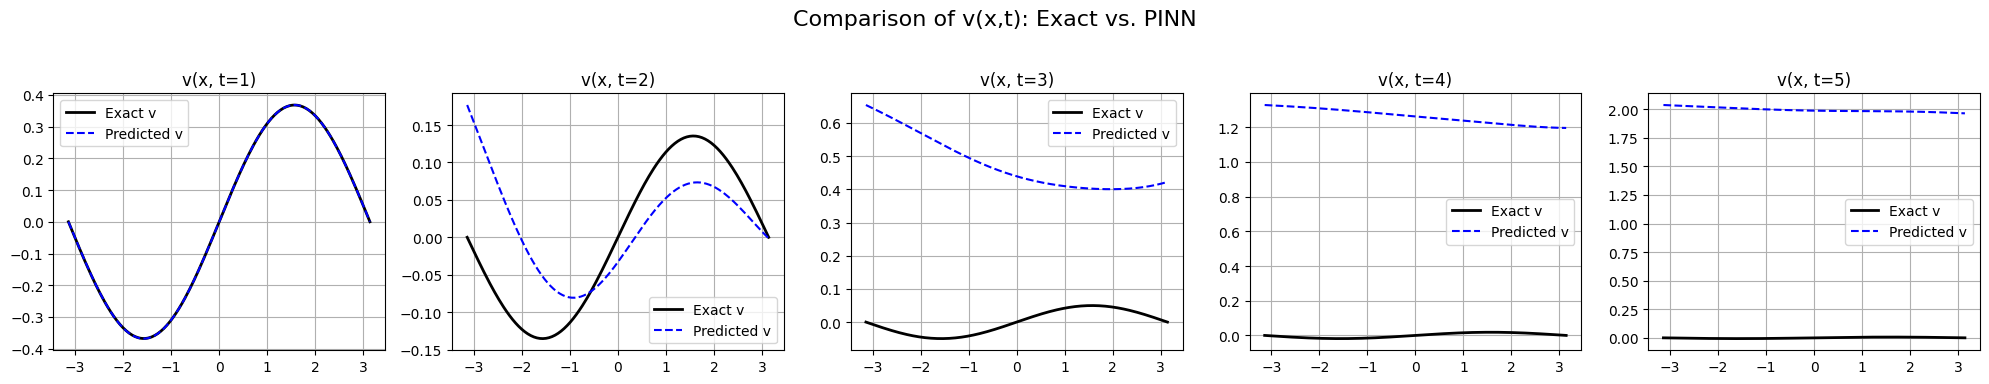

In [13]:
compare_pinn_vs_exact(model)


In [ ]:
import pandas as pd

def collect_error_metrics(model, t_eval, N_points=500):
    x = torch.linspace(xmin, xmax, N_points, device=device)
    t = torch.full_like(x, t_eval)
    X = torch.stack([t, x], dim=1)
    with torch.no_grad():
        u_pred, v_pred = model(X)
        u_true = u_exact(x, t)
        v_true = v_exact(x, t)

    u_err = torch.abs(u_pred.squeeze() - u_true)
    v_err = torch.abs(v_pred.squeeze() - v_true)

    u_Linf = u_err.max().item()
    u_L2 = torch.sqrt(torch.mean(u_err ** 2)).item()
    v_Linf = v_err.max().item()
    v_L2 = torch.sqrt(torch.mean(v_err ** 2)).item()

    return u_Linf, u_L2, v_Linf, v_L2

def show_error_comparison_table(model):
    # Reference errors
    raslan = {
        0.5: (3.71443e-4, 6.59721e-4),
        1.0: (4.50721e-4, 8.00531e-4)
    }
    shallal = {
        0.5: (5.45633e-5, 4.1676e-5),
        1.0: (6.34602e-5, 4.4651e-5)
    }

    # Collect your model's errors
    data = []
    for t_val in [0.5, 1.0]:
        u_Linf, u_L2, v_Linf, v_L2 = collect_error_metrics(model, t_val)
        data.append({
            "t": t_val,
            "Raslan_Linf": raslan[t_val][0],
            "Raslan_L2": raslan[t_val][1],
            "Shallal_Linf": shallal[t_val][0],
            "Shallal_L2": shallal[t_val][1],
            "PINN_u_Linf": u_Linf,
            "PINN_u_L2": u_L2,
            "PINN_v_Linf": v_Linf,
            "PINN_v_L2": v_L2,
        })

    df = pd.DataFrame(data)
    pd.set_option('display.float_format', '{:.5e}'.format)
    display(df)

# Run the comparison table
show_error_comparison_table(model)


,t,Raslan_Linf,Raslan_L2,Shallal_Linf,Shallal_L2,PINN_u_Linf,PINN_u_L2,PINN_v_Linf,PINN_v_L2
0,5.00000e-01,3.71443e-04,6.59721e-04,5.45633e-05,4.16760e-05,6.07431e-04,2.69582e-04,5.21123e-04,2.55049e-04
1,1.00000e+00,4.50721e-04,8.00531e-04,6.34602e-05,4.46510e-05,9.02054e-04,3.65110e-04,1.05559e-03,4.17350e-04
